# ML Term Paper - Code: Binary Models 
by Ann-Christin and Sarah 02/03/2021

## 1. Preparation

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.svm import l1_min_c
from time import time
from sklearn import linear_model

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from tabulate import tabulate

np.random.seed(0)
seed = 0

from sklearn import ensemble
from sklearn import tree as tree

# set color theme
sns.set_theme()

#specify your directories
# path = "E:\Data\krea\PIAAC" #enter your path here
path = "C:/Users/gust/Documents/ML_term_paper"
dir_lasso="results/models/" # where the outputs are saved 

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
os.chdir(path)
print("done")
data = pd.read_csv("data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


C:\Users\gust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,4,11,17,22,24,25,28,30,31,38,47,50,57,58,59,62,63,65,68,75,84,85,86,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(230691, 129)

In [3]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0','inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 
                           'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",

# further exclude 
dcl = dcl.drop(columns = ['d_q16b', 'b_q20b', 'b_d12h', 'b_q02a_t2', 'b_q11', 'b_q12e', 'd_q12a' , 'b_q04a', 'b_q16', 'b_q26b', 'b_q15c', 'd_q06c', 'b_q15b', 'd_q05a2', 
                          'b_q13', 'b_q15a', 'b_q16', 'b_q02a', 'b_q02a_t1', 'b_q05c', 'b_q10b', 'c_d06', 'd_q04', 'b_q12g', 'b_q12b', 'b_q12d'])

# logit exclude 
dcl = dcl.drop(columns = ['b_q14b', 'b_q26a_t', 'b_q14a'])


dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [4]:
#dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')
dcl['gender_r'] = dcl['gender_r'].astype('category')
dcl["age_r"] = pd.to_numeric(dcl["age_r"])
dcl['b_q12a'] = dcl['b_q12a'].astype('category') # yes/no open educational training
#dcl['b_q12b'] = pd.to_numeric(dcl["b_q12b"]) # number of open/distance educational trainings
#dcl["b_q12d"] = pd.to_numeric(dcl["b_q12d"]) # number of on-the-job training
#dcl['b_q12e'] = dcl['b_q12e'].astype('category')  # yes/no seminars training
dcl['b_q12f'] = pd.to_numeric(dcl["b_q12f"]) # number of seminars
#dcl['b_q12g'] = dcl['b_q12g'].astype('category')  # yes/no private training
dcl['b_q12h'] = pd.to_numeric(dcl["b_q12h"]) # number of private educational trainings
# dcl['j_q03a'] = dcl['j_q03a'].astype('category') # yes/no children
dcl['j_q03b'] = pd.to_numeric(dcl['j_q03b']) # number of children
#dcl['yrsqual_t'] = pd.to_numeric(dcl['yrsqual_t'])
dcl['yrsget'] = pd.to_numeric(dcl['yrsget'])
dcl['iscoskil4'] = dcl['iscoskil4'].astype('category')
#dcl['h_q05g'] = dcl['h_q05g'].astype('category') # Skill use everyday life - ICT - Computer - How often - Programming language  
#dcl['g_q05g'] = dcl['g_q05g'].astype('category') # skill use work - ICT programming lanugage how often
#dcl['g_q05'] = dcl['g_q05'].astype('category') # use computer at work yes/no

In [5]:
cate = dcl.select_dtypes(include=['object', 'category'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['computerexperience',
 'd_q09',
 'f_q07a',
 'b_q01b',
 'd_q06b',
 'd_q04_t',
 'g_q08',
 'b_q12a',
 'pared',
 'gender_r',
 'cntryid',
 'leaver1624',
 'd_q13c',
 'j_q04a',
 'edcat8',
 'g_q07',
 'd_q07a',
 'vet',
 'g_q05d',
 'c_q02a',
 'd_q14',
 'g_q05a',
 'g_q05e',
 'g_q05f',
 'g_q05g',
 'g_q05h',
 'isic1c',
 'f_q07b',
 'b_q10c',
 'd_q12c',
 'g_q05c',
 'd_q12b',
 'd_q06a',
 'd_q03',
 'g_q04',
 'b_q12c',
 'b_q10a',
 'g_q06',
 'nopaidworkever']

In [6]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,computerexperience_Yes,d_q09_A temporary employment agency contract,d_q09_An apprenticeship or other training scheme,d_q09_An indefinite contract,d_q09_No contract,d_q09_Other,f_q07a_Yes,"b_q01b_Engineering, manufacturing and construction",b_q01b_General programmes,b_q01b_Health and welfare,...,d_q06a_51 to 250 people,d_q06a_More than 1000 people,d_q03_The private sector (for example a company),d_q03_The public sector (for example the local government or a state school),g_q04_Yes,b_q12c_Yes,b_q10a_Yes,g_q06_Moderate,g_q06_Straightforward,nopaidworkever_Has not has paid work ever
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,1,1,0,1,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
230687,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
230688,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,1,0,1,0,0
230689,1,0,0,1,0,0,1,1,0,0,...,0,1,1,0,1,0,0,1,0,0


In [7]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies.head()
dummies.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 173 entries, computerexperience_Yes to skill_3
dtypes: uint8(173)
memory usage: 38.1 MB


In [8]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [9]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   readytolearn   226734 non-null  float64
 6   earnmthallppp  88508 non-null   float64
dtypes: float64(7)
memory usage: 12.3 MB


In [10]:
num_list = list(set(num))
num_list

['j_q03b',
 'c_q10a',
 'age_r',
 'readytolearn',
 'yrsget',
 'c_q09',
 'earnmthallppp']

In [11]:
# define X and y
on_job = dummies["b_q12c_Yes"] #define y here
open_educ = dummies["b_q12a_Yes"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
X = X.drop(columns = ["b_q12c_Yes", "b_q12a_Yes"])
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,computerexperience_Yes,...,d_q03_The private sector (for example a company),d_q03_The public sector (for example the local government or a state school),g_q04_Yes,b_q10a_Yes,g_q06_Moderate,g_q06_Straightforward,nopaidworkever_Has not has paid work ever,skill_1,skill_2,skill_3
0,0,0,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,NaN,NaN,19.0,NaN,NaN,2.164922,NaN,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,1,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,NaN,NaN,8.0,NaN,NaN,1.177736,NaN,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
230687,0,0,NaN,NaN,11.0,NaN,NaN,2.156445,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230688,1,0,NaN,NaN,11.0,NaN,NaN,2.383062,NaN,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
230689,0,0,NaN,NaN,12.0,NaN,NaN,1.751830,NaN,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## 2. Logit

### 2.1 Logit 'on_job'

In [12]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]


In [13]:
X

,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,computerexperience_Yes,d_q09_A temporary employment agency contract,d_q09_An apprenticeship or other training scheme,...,d_q06a_More than 1000 people,d_q03_The private sector (for example a company),d_q03_The public sector (for example the local government or a state school),g_q04_Yes,b_q10a_Yes,g_q06_Moderate,g_q06_Straightforward,skill_1,skill_2,skill_3
18418,33.0,2.0,11.0,6.0,1.0,2.361800,2500.0000,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
18423,43.0,1.0,11.0,24.0,1.0,1.124230,1343.1400,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
18433,53.0,2.0,9.0,27.0,2.0,0.788280,980.3900,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
18434,42.0,1.0,11.0,18.0,1.0,1.470600,1314.2200,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
18439,50.0,1.0,11.0,29.0,1.0,0.664940,1460.7800,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225548,43.0,2.0,15.0,23.0,1.0,1.239026,6153.8480,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
225552,42.0,2.0,12.0,22.0,1.0,1.177736,3509.6165,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
225554,24.0,1.0,12.0,6.0,15.0,2.004488,2500.0007,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
225555,51.0,3.0,8.0,35.0,2.0,1.002733,929.0080,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                       Results: Logit
Model:                                    Logit                                 Pseudo R-squared:                      inf   
Dependent Variable:                       on_job                                AIC:                                   inf   
Date:                                     2021-03-08 14:59                      BIC:                                   inf   
No. Observations:                         40950                                 Log-Likelihood:                        -inf  
Df Model:                                 151                                   LL-Null:                               0.0000
Df Residuals:                             40798                                 LLR p-value:                           1.0000
Converged:                                1.0000                                Scale:                                 1.0000
No. Iterations:                           7.0000

## 2.2 Logit 'off job'

In [15]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]


In [16]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                       Results: Logit
Model:                                    Logit                                 Pseudo R-squared:                      inf   
Dependent Variable:                       open_educ                             AIC:                                   inf   
Date:                                     2021-03-08 14:59                      BIC:                                   inf   
No. Observations:                         40950                                 Log-Likelihood:                        -inf  
Df Model:                                 151                                   LL-Null:                               0.0000
Df Residuals:                             40798                                 LLR p-value:                           1.0000
Converged:                                1.0000                                Scale:                                 1.0000
No. Iterations:                           8.0000

## 3. Logit with Penalty

## 3.1. 'on job training'

In [17]:
nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]



# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= seed)



In [18]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [ ]:
# regularization path

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_on_job.png', bbox_inches='tight')
plt.show()

In [54]:
# run logistic lasso with 5 fold cross validation
clf = LogisticRegressionCV(Cs=20,cv=5,penalty='l1',solver='liblinear',refit=True)
logit = clf.fit(X_train, y_train)

print(np.count_nonzero(clf.coef_)) 
y_pred=logit.predict(X_test)

print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
C = float(logit.C_)
print(C)



152
Coefficient of each feature: [[-1.73090545e-02  6.48862986e-03  3.23997758e-02  1.48830468e-02
   4.07623840e-03  6.88913774e-02 -4.95059297e-08  3.89252855e-01
   1.52316367e-01 -6.85863607e-02  1.18794395e-04 -2.49487977e-01
   2.68224519e-01  9.19624872e-02 -3.12127374e-03 -7.94880070e-02
   1.92744063e-01 -8.30876139e-02  6.23138362e-02 -4.54430740e-02
  -7.09438126e-03  9.55664812e-02  6.28176069e-02 -1.00635150e-02
   8.22427766e-02  1.12576594e-01 -1.62508024e-01 -1.19124922e-01
  -6.24560594e-02 -4.92441054e-02 -2.56628563e-01 -1.99704438e+00
  -8.16074164e-01 -3.49184213e-01  3.86236489e-01 -2.13450782e-01
   1.83450793e-01  8.78039043e-02 -8.33831238e-01 -3.88731294e-01
  -8.77568656e-01  4.68008751e-01 -8.87687546e-02 -1.42131209e+00
  -1.25974044e+00 -1.10661643e+00 -4.07782507e-01 -1.79463308e+00
  -1.50360430e+00 -6.24083021e-01 -6.36464142e-01  8.90738119e-01
  -2.42009766e-01 -1.68535536e+00  3.10305565e-01 -6.38578952e-01
  -1.51086622e+00  2.70682985e-01 -1.030223

In [55]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10929,    68],
       [ 1200,    88]], dtype=int64)

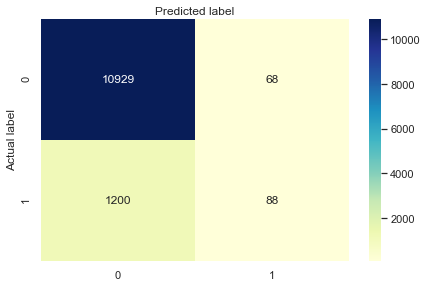

In [56]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('results\plots\confusion_on_job.png', bbox_inches='tight')

In [57]:
imp = pd.DataFrame(clf.coef_, index = ["Coefficients"]).T
imp['Feature'] = list(X_train.columns)
imp

,Coefficients,Feature
0,-0.017309,age_r
1,0.006489,j_q03b
2,0.032400,yrsget
3,0.014883,c_q09
4,0.004076,c_q10a
...,...,...
147,0.037476,g_q06_Moderate
148,-0.044257,g_q06_Straightforward
149,0.101065,skill_1
150,0.004152,skill_2


In [58]:
index = imp[(imp['Coefficients'] == 0)].index
imp.drop(index, inplace=True)
imp= imp[~imp['Feature'].astype(str).str.startswith('isic1c')]
imp= imp[~imp['Feature'].astype(str).str.startswith('cntryid')]
imp.reset_index(drop=True, inplace=True)
imp


,Coefficients,Feature
0,-0.017309,age_r
1,0.006489,j_q03b
2,0.032400,yrsget
3,0.014883,c_q09
4,0.004076,c_q10a
...,...,...
97,0.037476,g_q06_Moderate
98,-0.044257,g_q06_Straightforward
99,0.101065,skill_1
100,0.004152,skill_2


In [59]:
headers = ["Coefficients", "Feature"]
print(tabulate(imp, headers, tablefmt="pipe"))

|     |   Coefficients | Feature                                                                      |
|----:|---------------:|:-----------------------------------------------------------------------------|
|   0 |   -0.0173091   | age_r                                                                        |
|   1 |    0.00648863  | j_q03b                                                                       |
|   2 |    0.0323998   | yrsget                                                                       |
|   3 |    0.014883    | c_q09                                                                        |
|   4 |    0.00407624  | c_q10a                                                                       |
|   5 |    0.0688914   | readytolearn                                                                 |
|   6 |   -4.95059e-08 | earnmthallppp                                                                |
|   7 |    0.389253    | computerexperience_Yes                 

In [60]:
imp.sort_values("Coefficients").head(30)

,Coefficients,Feature
30,-0.655047,"leaver1624_Not in education, did not complete ..."
73,-0.390016,g_q05h_Never
34,-0.375997,d_q13c_Never
50,-0.308108,d_q14_Extremely dissatisfied
81,-0.277454,d_q12c_Less than 1 month
93,-0.277048,d_q03_The private sector (for example a company)
86,-0.250353,g_q05c_Never
11,-0.249488,d_q09_No contract
88,-0.177648,d_q12b_This level is necessary
26,-0.162508,g_q08_Yes


In [61]:
imp.sort_values("Coefficients", ascending = False).head(30)

,Coefficients,Feature
96,0.801725,b_q10a_Yes
95,0.675257,g_q04_Yes
76,0.431681,b_q10c_Somewhat useful
7,0.389253,computerexperience_Yes
39,0.350122,edcat8_Tertiary – bachelor degree (ISCED 5A)
36,0.343026,"edcat8_Post-secondary, non-tertiary (ISCED 4A-..."
40,0.313690,edcat8_Tertiary – master degree (ISCED 5A)
92,0.293531,d_q06a_More than 1000 people
90,0.280167,d_q06a_251 to 1000 people
12,0.268225,d_q09_Other


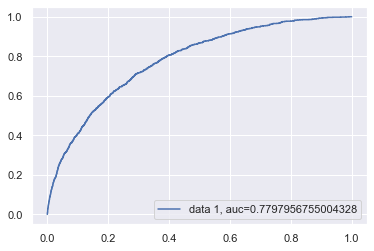

In [62]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_on_job.png', bbox_inches='tight')
plt.show()

### 3.2 open education

In [63]:
nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= seed)



In [64]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [ ]:
# regularization path (takes a lot of time)

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_open_educ.png', bbox_inches='tight')
plt.show()

In [83]:
# run logistic lasso with 5 fold cross validation
clf = LogisticRegressionCV(Cs=20,cv=5,penalty='l1',solver='liblinear',refit=True)
logit = clf.fit(X_train, y_train)

print(np.count_nonzero(clf.coef_)) 
y_pred=logit.predict(X_test)

print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
C = float(logit.C_)
print(C)

90
Coefficient of each feature: [[-1.76953377e-02  0.00000000e+00  4.74509226e-02  1.31248098e-02
   4.48319122e-03  8.61567059e-02 -3.07032737e-08  2.20386288e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.12470145e-01
   0.00000000e+00  7.51546417e-02  0.00000000e+00 -1.65668828e-02
   1.79973185e-01  0.00000000e+00  1.39164882e-02  0.00000000e+00
   0.00000000e+00  9.40461908e-02  5.70971033e-02 -7.82241433e-03
   1.40560819e-02  8.29085903e-02 -6.56783587e-02 -4.26239938e-02
   0.00000000e+00 -2.47729810e-02  0.00000000e+00 -5.97073131e-01
  -1.52445009e-01  0.00000000e+00  7.22570888e-01  0.00000000e+00
   1.62561789e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.21545588e-02  6.68741450e-01  0.00000000e+00 -7.37408420e-01
  -6.03903882e-01 -4.88143138e-01  5.44157244e-02 -1.12288049e+00
  -8.54109432e-01 -3.60667128e-02 -1.00471661e-01  1.23364014e+00
   1.54970252e-01 -1.04851157e+00  6.56194562e-01  0.00000000e+00
  -8.14583115e-01  5.97058965e-01 -4.5517454

In [84]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10965,    32],
       [ 1224,    64]], dtype=int64)

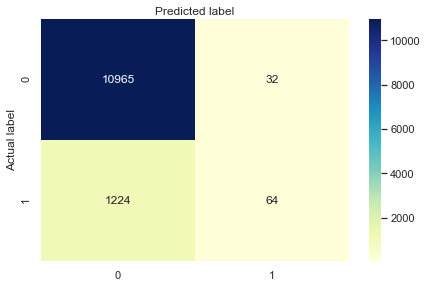

In [85]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#plt.savefig('results\plots\confusion_open_educ.png', bbox_inches='tight')

In [86]:
imp = pd.DataFrame(logit.coef_, index = ["Coefficients"]).T
imp['Feature'] = list(X_train.columns)
imp

,Coefficients,Feature
0,-0.017695,age_r
1,0.000000,j_q03b
2,0.047451,yrsget
3,0.013125,c_q09
4,0.004483,c_q10a
...,...,...
147,0.036645,g_q06_Moderate
148,0.000000,g_q06_Straightforward
149,0.110280,skill_1
150,0.000000,skill_2


In [87]:
index = imp[(imp['Coefficients'] == 0)].index
imp.drop(index, inplace=True)
imp= imp[~imp['Feature'].astype(str).str.startswith('isic1c')]
imp= imp[~imp['Feature'].astype(str).str.startswith('cntryid')]
imp.reset_index(drop=True, inplace=True)
imp


,Coefficients,Feature
0,-0.017695,age_r
1,0.047451,yrsget
2,0.013125,c_q09
3,0.004483,c_q10a
4,0.086157,readytolearn
...,...,...
56,-0.238538,d_q03_The private sector (for example a company)
57,0.562520,g_q04_Yes
58,0.782520,b_q10a_Yes
59,0.036645,g_q06_Moderate


In [88]:
headers = ["Coefficients", "Feature"]
print(tabulate(imp, headers, tablefmt="pipe"))

|    |   Coefficients | Feature                                                |
|---:|---------------:|:-------------------------------------------------------|
|  0 |   -0.0176953   | age_r                                                  |
|  1 |    0.0474509   | yrsget                                                 |
|  2 |    0.0131248   | c_q09                                                  |
|  3 |    0.00448319  | c_q10a                                                 |
|  4 |    0.0861567   | readytolearn                                           |
|  5 |   -3.07033e-08 | earnmthallppp                                          |
|  6 |    0.220386    | computerexperience_Yes                                 |
|  7 |   -0.21247     | d_q09_No contract                                      |
|  8 |    0.0751546   | f_q07a_Yes                                             |
|  9 |   -0.0165669   | b_q01b_General programmes                              |
| 10 |    0.179973    | b_q0

In [71]:
imp.sort_values("Coefficients").head(30)

,Coefficients,Feature
29,-0.570962,"leaver1624_Not in education, did not complete ..."
72,-0.383366,g_q05h_Never
33,-0.380295,d_q13c_Never
92,-0.311494,d_q03_The private sector (for example a company)
49,-0.288599,d_q14_Extremely dissatisfied
80,-0.281571,d_q12c_Less than 1 month
11,-0.264827,d_q09_No contract
85,-0.244845,g_q05c_Never
36,-0.187126,edcat8_Primary or less (ISCED 1 or less)
87,-0.176593,d_q12b_This level is necessary


In [72]:
imp.sort_values("Coefficients", ascending = False).head(30)

,Coefficients,Feature
95,0.782611,b_q10a_Yes
94,0.666013,g_q04_Yes
75,0.427886,b_q10c_Somewhat useful
7,0.334573,computerexperience_Yes
38,0.321688,edcat8_Tertiary – bachelor degree (ISCED 5A)
35,0.305675,"edcat8_Post-secondary, non-tertiary (ISCED 4A-..."
39,0.285849,edcat8_Tertiary – master degree (ISCED 5A)
91,0.281488,d_q06a_More than 1000 people
89,0.268349,d_q06a_251 to 1000 people
73,0.245253,f_q07b_Yes


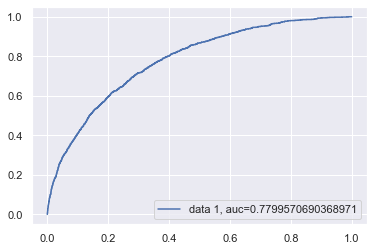

In [73]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_open_educ.png', bbox_inches='tight')
plt.show()

In [74]:
# out of sample result with lasso 
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', logit.score(X_test_std, y_test))
print('In-sample Rsq: % .4f'
     % logit.score(X_train, y_train))
print('Out-of-sample Rsq: % .4f'
     % logit.score(X_test, y_test))

Training accuracy: 0.7225885225885226
Test accuracy: 0.7227513227513227
In-sample Rsq:  0.8951
Out-of-sample Rsq:  0.8971


### compare to logit without lasso 'on-job'

In [75]:
# compare to logit without lasso 

nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= seed)


regr =LogisticRegression(penalty='none', random_state=seed)
regr.fit(X_train, y_train)



# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients: ' )
print(regr.coef_ )

y_pred_in = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
print('Training accuracy:', regr.score(X_train_std, y_train))
print('Test accuracy:', regr.score(X_test_std, y_test))
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))

Intercept: -0.000
Coefficients: 
[[-6.92267214e-03 -3.22425393e-04 -1.33833091e-03 -2.97390962e-03
  -2.84428032e-04 -2.11510029e-04 -6.29508522e-08 -1.02735512e-04
  -6.20296316e-06 -1.82406329e-06 -7.89566726e-05 -3.54153732e-05
  -2.48965704e-06 -1.24583954e-04 -2.44125132e-05 -3.20704146e-05
   7.42758278e-06 -5.54599949e-06 -4.38543724e-06 -2.20239525e-05
  -5.64253125e-06  3.99944261e-06 -8.80914763e-06 -1.26668739e-04
  -1.29253563e-05  1.60791101e-05 -6.85687846e-06 -8.13601220e-06
  -9.25694845e-05 -6.35381151e-05 -3.42832705e-06 -6.56412110e-06
  -5.04993672e-06 -1.39094489e-05 -9.22431838e-06 -3.97024056e-06
  -1.14500017e-06 -9.15990003e-07 -2.82762217e-06 -1.18598019e-06
  -8.29926958e-06 -2.81777989e-06 -1.33822889e-06 -5.74722860e-06
  -5.16070406e-06  2.58708148e-06  3.43810243e-06 -1.93916744e-05
  -8.14870860e-07 -1.01655062e-05 -9.36364628e-06 -6.72767778e-06
   6.08462668e-06 -9.90896980e-06 -1.03630539e-05 -1.09451398e-05
  -1.24898992e-05 -3.24565123e-06  2.897731

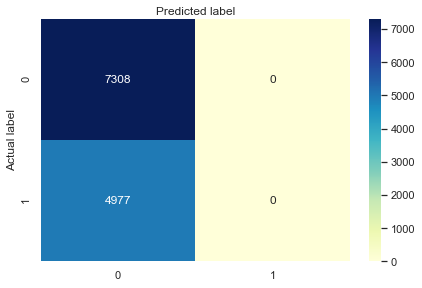

In [76]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_out)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\logit_confusion_open_educ.png', bbox_inches='tight')

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_out))

              precision    recall  f1-score   support

           0       0.59      1.00      0.75      7308
           1       0.00      0.00      0.00      4977

    accuracy                           0.59     12285
   macro avg       0.30      0.50      0.37     12285
weighted avg       0.35      0.59      0.44     12285



C:\Users\gust\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### compare to logit without lasso 'open educ'

In [78]:
# compare to logit without lasso 

nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= seed)


regr =LogisticRegression(penalty='none', random_state=seed)
regr.fit(X_train, y_train)



# to see the coefficients
print('Intercept: %.3f' %regr.intercept_)
print('Coefficients: ' )
print(regr.coef_ )

y_pred_in = regr.predict(X_train)
y_pred_out = regr.predict(X_test)
print('Training accuracy:', regr.score(X_train_std, y_train))
print('Test accuracy:', regr.score(X_test_std, y_test))
# In-sample R-sq.
print('In-sample Rsq: %.3f'
      % r2_score(y_train, y_pred_in))
print('Out-of-sample Rsq: %.3f'
      % r2_score(y_test, y_pred_out))

Intercept: -0.001
Coefficients: 
[[-3.66837908e-02 -1.78407077e-03 -8.70842496e-03 -1.64777626e-02
  -1.45485453e-03 -1.42548434e-03  2.63693279e-08 -6.60608683e-04
  -2.60736046e-05 -7.28924554e-06 -5.56196197e-04 -1.05468846e-04
  -1.04651552e-05 -6.79339445e-04 -1.32790470e-04 -1.27843591e-04
  -4.30035134e-05 -3.28685071e-05 -2.87937863e-05 -9.18804795e-05
  -6.80393978e-05 -3.16251267e-05 -9.71681414e-05 -5.50342741e-04
  -7.49278615e-05 -6.62787060e-06 -4.34014300e-05 -7.97047092e-05
  -4.05224236e-04 -3.02094827e-04 -1.99710306e-05 -1.83727904e-05
  -2.46511850e-05 -4.12336652e-05 -3.00890296e-05 -2.63975639e-05
  -5.72489609e-06 -8.56623638e-06 -6.52544182e-06 -6.95525071e-06
  -2.53651122e-05 -1.29387744e-05 -1.18672127e-05 -5.81630983e-05
  -3.15049582e-05 -5.96429921e-05 -3.94505106e-07 -6.80922235e-05
  -3.07916379e-05 -2.05661335e-05 -4.26445843e-05  4.13383425e-06
  -1.02497366e-05 -2.84893240e-05 -2.90977309e-05 -3.74774655e-05
  -6.92783860e-05 -1.57962192e-05 -6.257078

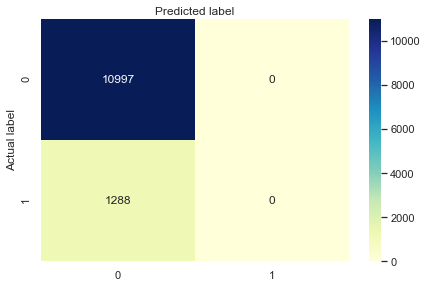

In [79]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_out)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\logit_confusion_open_educ.png', bbox_inches='tight')

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_out))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94     10997
           1       0.00      0.00      0.00      1288

    accuracy                           0.90     12285
   macro avg       0.45      0.50      0.47     12285
weighted avg       0.80      0.90      0.85     12285



C:\Users\gust\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
y_test.describe()

count    12285.000000
mean         0.104843
std          0.306364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: open_educ, dtype: float64